In [1]:
import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, dbscan

import hdbscan

%matplotlib inline

In [2]:

def sigmoid(x):
    #return np.tanh(x)
    return 1/(1+np.exp(-x))

def sigmoid_log(x):
    return sigmoid(np.log(x))

In [3]:
os.chdir("L:/lab_research/RES-Folder-UPOD/Celldynclustering")
celldyn = pd.read_sas("E_ResearchData/2_ResearchData/celldyn.sas7bdat")

D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:800: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._byte_chunk[jb, :].view(dtype=self.byte_order + "d")
D:\Miniconda3\envs\embcelldyn\lib\site-packages\pandas\io\sas\sas7bdat.py:809: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  rslt[name] = self._string_chunk[js, :]


In [ ]:
celldyn['afnamejaar']  = pd.to_datetime(celldyn.afname_dt).dt.year

In [4]:
meas_columns = [c for c in celldyn.columns if 'c_b' in c]
mode_columns = [c for c in celldyn.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn if 'c_s_' in c.lower()]

In [13]:
np.any(celldyn[c_s_columns] == 0,axis = 1)

0           True
1           True
2           True
3           True
4          False
           ...  
3107031    False
3107032    False
3107033    False
3107034     True
3107035     True
Length: 3107036, dtype: bool

In [30]:
c_s_columns[-3:]

['c_s_retc', 'c_s_pretc', 'c_s_irf']

In [32]:
for c in c_s_columns:
    print(c,len(celldyn.loc[celldyn[c] == 0]))

c_s_wbc 152
c_s_wvf 152
c_s_neu 152
c_s_seg 152
c_s_bnd 152
c_s_ig 152
c_s_lym 152
c_s_lyme 152
c_s_vlym 152
c_s_mon 152
c_s_mone 152
c_s_blst 152
c_s_eos 152
c_s_bas 152
c_s_nrbc 152
c_s_pneu 152
c_s_pseg 152
c_s_pbnd 152
c_s_pig 152
c_s_plym 152
c_s_plyme 152
c_s_pvlym 152
c_s_pmon 152
c_s_pmone 152
c_s_pblst 152
c_s_peos 152
c_s_pbas 152
c_s_pnrbc 152
c_s_rbci 152
c_s_rbco 152
c_s_hb 152
c_s_mcv 152
c_s_rdw 152
c_s_mch 152
c_s_mchc 152
c_s_ht 152
c_s_plt 155
c_s_plto 152
c_s_plti 152
c_s_mpv 152
c_s_pct 152
c_s_pdw 152
c_s_retc 613135
c_s_pretc 613135
c_s_irf 613135


In [19]:
celldyn.loc[celldyn.c_s_rdw == 0][c_s_columns].sum(axis = 1).sum()

0.0

In [17]:
celldyn.loc[np.any(celldyn[c_s_columns] == 0,axis = 1)][c_s_columns].sum(axis = 1).sum()

29244550.0

In [38]:
cluster_columns = c_s_columns+alrt_columns
celldyn = celldyn[cluster_columns].dropna()
clust_data = celldyn.sample(250000)

### try ARM

In [20]:
from mlxtend.preprocessing import TransactionEncoder

In [21]:
fin_c_s_cols = ['c_s_wbc', 'c_s_wvf', 'c_s_neu', 'c_s_seg', 'c_s_lym','c_s_vlym', 'c_s_mon', 'c_s_mone', 'c_s_blst',
       'c_s_eos', 'c_s_bas', 'c_s_nrbc', 'c_s_rbci', 'c_s_rbco', 'c_s_hb', 'c_s_mcv', 'c_s_rdw', 'c_s_mch',
       'c_s_mchc', 'c_s_ht', 'c_s_plt', 'c_s_plto', 'c_s_plti', 'c_s_mpv',
       'c_s_pct', 'c_s_pdw', 'c_s_retc', 'c_s_pretc', 'c_s_irf']

In [47]:
arm_data = celldyn.sample(250000)
arm_data[alrt_columns] = np.where(arm_data[alrt_columns] == 1,True,False)
arm_data[fin_c_s_cols] = np.where(arm_data[fin_c_s_cols] == 1,False,True)

In [48]:
from mlxtend.frequent_patterns import apriori,association_rules
frequent_candidates = apriori(arm_data[fin_c_s_cols], min_support=0.05, use_colnames=True,low_memory=True)


In [49]:
rules = association_rules(frequent_candidates, metric="lift", min_threshold=1)


In [50]:
arm_data.loc[arm_data.c_s_retc & arm_data.c_s_neu][["c_s_pretc"]].sum()/len(arm_data.loc[arm_data.c_s_retc & arm_data.c_s_neu]["c_s_pretc"])

c_s_pretc    0.798605
dtype: float64

In [52]:
pd.set_option("display.max_rows",100)
rules[ (rules['confidence'] >= 0.8) ]


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
15,(c_s_rbci),(c_s_retc),0.054020,0.247956,0.054020,1.000000,4.032974,0.040625,inf
16,(c_s_mpv),(c_s_pct),0.063776,0.063784,0.063636,0.997805,15.643497,0.059568,4.264865e+02
17,(c_s_pct),(c_s_mpv),0.063784,0.063776,0.063636,0.997680,15.643497,0.059568,4.034872e+02
18,(c_s_mpv),(c_s_pdw),0.063776,0.062684,0.062664,0.982564,15.674877,0.058666,5.375743e+01
19,(c_s_pdw),(c_s_mpv),0.062684,0.063776,0.062664,0.999681,15.674877,0.058666,2.934313e+03
20,(c_s_pdw),(c_s_pct),0.062684,0.063784,0.062656,0.999553,15.670910,0.058658,2.095920e+03
21,(c_s_pct),(c_s_pdw),0.063784,0.062684,0.062656,0.982315,15.670910,0.058658,5.300156e+01
22,(c_s_retc),(c_s_pretc),0.247956,0.218976,0.218972,0.883108,4.032900,0.164676,6.681603e+00
23,(c_s_pretc),(c_s_retc),0.218976,0.247956,0.218972,0.999982,4.032900,0.164676,4.116990e+04
24,(c_s_retc),(c_s_irf),0.247956,0.214824,0.214820,0.866363,4.032898,0.161553,5.875456e+00


### try clustering

In [39]:
hdb_cl = hdbscan.HDBSCAN(min_samples = 2500,metric = 'jaccard')

In [ ]:
hdb_cl.fit(clust_data)

In [ ]:
clust_data['labels'] = hdb_cl.labels_

### try PCA

AttributeError: 'AxesSubplot' object has no attribute 'lineplot'

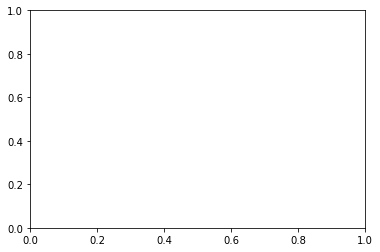

In [12]:
var_ex = []
for i in range(2,20):
    pca = PCA(n_components=i)
    pca.fit(celldyn[cluster_columns].dropna())
    var_ex.append(pca.explained_variance_)
    
    


In [15]:
pca = PCA(n_components = 8)
transformed_data = pca.fit_transform(clust_data.dropna())

In [32]:
km = KMeans(n_clusters=3).fit(transformed_data)

In [38]:
celldyn = celldyn.dropna()
celldyn['km_labels']  = km.labels_

### check clusters after pca

In [17]:
plot_df = pd.DataFrame(data=transformed_data, columns=[f'd_{i}' for i in range(8)], index=clust_data.index)
plot_df['labels'] = hdb_cl.labels_
#reduce_dim = min([6, reduce_dim])


In [38]:
cols_to_plot = ['c_s_wbc', 'c_s_wvf', 'c_s_neu', 'c_s_seg', 'c_s_lym','c_s_vlym', 'c_s_mon', 'c_s_mone', 'c_s_blst',
       'c_s_eos', 'c_s_bas', 'c_s_nrbc','c_s_rbci', 'c_s_rbco', 'c_s_hb', 'c_s_mcv', 'c_s_rdw', 'c_s_mch','c_s_mchc', 'c_s_ht',
        'c_s_plt', 'c_s_plto', 'c_s_plti', 'c_s_mpv','c_s_pct', 'c_s_pdw', 'c_s_retc', 'c_s_pretc', 'c_s_irf']

In [30]:
pd.set_option("display.max_columns",50)
clust_data[c_s_columns].corr()

,c_s_wbc,c_s_wvf,c_s_neu,c_s_seg,c_s_bnd,c_s_ig,c_s_lym,c_s_lyme,c_s_vlym,c_s_mon,c_s_mone,c_s_blst,c_s_eos,c_s_bas,c_s_nrbc,c_s_pneu,c_s_pseg,c_s_pbnd,c_s_pig,c_s_plym,c_s_plyme,c_s_pvlym,c_s_pmon,c_s_pmone,c_s_pblst,c_s_peos,c_s_pbas,c_s_pnrbc,c_s_rbci,c_s_rbco,c_s_hb,c_s_mcv,c_s_rdw,c_s_mch,c_s_mchc,c_s_ht,c_s_plt,c_s_plto,c_s_plti,c_s_mpv,c_s_pct,c_s_pdw,c_s_retc,c_s_pretc,c_s_irf
c_s_wbc,1.000000,0.859171,0.117218,0.818599,0.818599,0.818599,0.233961,0.829467,0.829467,0.217610,0.828545,0.833622,0.807702,0.844481,0.288532,0.117263,0.818547,0.818547,0.818547,0.233938,0.829415,0.829415,0.217588,0.828492,0.833570,0.807650,0.844429,0.293668,0.440427,0.551937,0.554160,0.215548,0.215388,0.215531,0.215690,0.215723,0.220464,0.220831,0.249845,0.324261,0.236292,0.323171,0.266628,0.064950,0.067026
c_s_wvf,0.859171,1.000000,0.155394,0.953530,0.953530,0.953530,0.282535,0.965602,0.965602,0.264119,0.964563,0.970281,0.941268,0.982846,0.345034,0.155424,0.953504,0.953504,0.953504,0.282519,0.965575,0.965575,0.264104,0.964537,0.970254,0.941241,0.982820,0.350820,0.337782,0.690889,0.697933,0.286172,0.286060,0.286146,0.286259,0.286272,0.239993,0.240101,0.357276,0.460184,0.251813,0.459145,0.211345,0.103952,0.118501
c_s_neu,0.117218,0.155394,1.000000,0.159070,0.159070,0.159070,0.070188,0.167236,0.167236,0.218289,0.168879,0.167046,0.165080,0.157231,0.147850,0.999989,0.159068,0.159068,0.159068,0.070187,0.167234,0.167234,0.218288,0.168877,0.167045,0.165078,0.157229,0.150991,0.079084,0.112461,0.112649,0.089126,0.089065,0.089175,0.089236,0.089239,0.107895,0.108351,0.151380,0.160212,0.131431,0.159091,0.021518,-0.029410,-0.039612
c_s_seg,0.818599,0.953530,0.159070,1.000000,1.000000,1.000000,0.292468,0.927373,0.927373,0.285275,0.934246,0.939630,0.980362,0.944880,0.338736,0.159098,0.999976,0.999976,0.999976,0.292454,0.927348,0.927348,0.285261,0.934221,0.939606,0.980338,0.944856,0.344173,0.327352,0.659324,0.665794,0.279983,0.279861,0.279932,0.280054,0.280069,0.237315,0.237465,0.354011,0.450305,0.252437,0.448971,0.203455,0.095999,0.108414
c_s_bnd,0.818599,0.953530,0.159070,1.000000,1.000000,1.000000,0.292468,0.927373,0.927373,0.285275,0.934246,0.939630,0.980362,0.944880,0.338736,0.159098,0.999976,0.999976,0.999976,0.292454,0.927348,0.927348,0.285261,0.934221,0.939606,0.980338,0.944856,0.344173,0.327352,0.659324,0.665794,0.279983,0.279861,0.279932,0.280054,0.280069,0.237315,0.237465,0.354011,0.450305,0.252437,0.448971,0.203455,0.095999,0.108414
c_s_ig,0.818599,0.953530,0.159070,1.000000,1.000000,1.000000,0.292468,0.927373,0.927373,0.285275,0.934246,0.939630,0.980362,0.944880,0.338736,0.159098,0.999976,0.999976,0.999976,0.292454,0.927348,0.927348,0.285261,0.934221,0.939606,0.980338,0.944856,0.344173,0.327352,0.659324,0.665794,0.279983,0.279861,0.279932,0.280054,0.280069,0.237315,0.237465,0.354011,0.450305,0.252437,0.448971,0.203455,0.095999,0.108414
c_s_lym,0.233961,0.282535,0.070188,0.292468,0.292468,0.292468,1.000000,0.290906,0.290906,0.298297,0.293694,0.294733,0.284095,0.285844,0.181750,0.070195,0.292463,0.292463,0.292463,0.999997,0.290900,0.290900,0.298294,0.293688,0.294727,0.284089,0.285838,0.160673,0.126991,0.197999,0.199571,0.125504,0.125541,0.125507,0.125471,0.125496,0.105895,0.106356,0.224150,0.191021,0.134240,0.188286,0.089834,0.041572,0.019674
c_s_lyme,0.829467,0.965602,0.167236,0.927373,0.927373,0.927373,0.290906,1.000000,1.000000,0.267908,0.982006,0.987140,0.915773,0.957003,0.347817,0.167264,0.927347,0.927347,0.927347,0.290892,0.999976,0.999976,0.267894,0.981981,0.987115,0.915747,0.956978,0.352969,0.334861,0.667498,0.674142,0.287064,0.286959,0.287035,0.287140,0.287154,0.249716,0.249860,0.359928,0.463624,0.264403,0.462580,0.212096,0.102941,0.115168
c_s_vlym,0.829467,0.965602,0.167236,0.927373,0.927373,0.927373,0.290906,1.000000,1.000000,0.267908,0.982006,0.987140,0.915773,0.957003,0.347817,0.167264,0.927347,0.927347,0.927347,0.290892,0.999976,0.999976,0.267894,0.981981,0.987115,0.915747,0.956978,0.352969,0.334861,0.667498,0.674142,0.287064,0.286959,

In [49]:
len(cols_to_plot)

29

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000000000A8BBEE0> (for post_execute):


KeyboardInterrupt: 

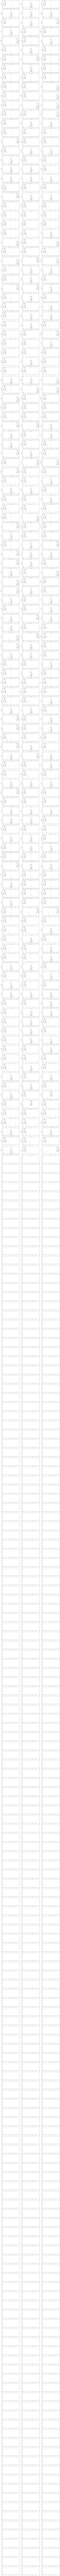

In [53]:
num_rows = int(np.ceil(len(cols_to_plot)*len(cols_to_plot)/3))
fig, ax = plt.subplots(ncols=3, nrows=num_rows, figsize=(18, 3*num_rows))
k = 0
rest_cols = cols_to_plot[1:]

for ki in range(len(cols_to_plot)):
    rest_cols = rest_cols[1:]
    for kj in range(len(rest_cols)): 
        i = int(k/3)
        j = k%3
        if num_rows > 1:
            sns.scatterplot(data=clust_data.sample(20000), x=cols_to_plot[ki], y=rest_cols[kj],
                            ax=ax[i,j], 
                            hue = 'labels',alpha=0.5)
        else:
            sns.scatterplot(data=clust_data.sample(20000),x=cols_to_plot[ki], y=rest_cols[kj],
                            ax=ax[k], 
                             hue = 'labels',alpha=0.5)
        k += 1
        